<a href="https://colab.research.google.com/github/v1t3ls0n/ml_intro_course_mmn11/blob/main/notebooks/%D7%9E%D7%91%D7%95%D7%90%20%D7%9C%D7%9C%D7%9E%D7%99%D7%93%D7%94%20%D7%97%D7%99%D7%A9%D7%95%D7%91%D7%99%D7%AA%20-%20%D7%9E%D7%9E%D7%9F%2011%20-%20%D7%92%D7%99%D7%90%20%D7%95%D7%99%D7%98%D7%9C%D7%96%D7%95%D7%9F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Maman 11 By Guy Vitelson


##**If you run this within Google Collab, Dont Worry!**
all the missing python files/directories/modules will be automatically feteched from my github repository

**My GitHub Profile** : https://github.com/v1t3ls0n

**The Repository:** https://github.com/v1t3ls0n/ml_intro_course_mmn11

# Overview



## MNIST Digit Classification Using Perceptron Learning Algorithm (PLA)

**Objective:**  
This notebook compares the performance of two variants of the Perceptron Learning Algorithm (PLA) on the MNIST digit classification task:
- **Clean PLA:** Standard perceptron without enhancements.
- **Pocket PLA:** Enhanced perceptron that stores the best-performing weights during training (using the Pocket algorithm).

**Dataset:**  
- MNIST dataset consisting of 60,000 training samples and 10,000 test samples.
- The images are normalized to the range [0, 1] and a bias term is added, resulting in input samples with 785 features.

**Evaluation Metrics:**  
- **Confusion Matrices:** Provides a detailed view of how well each digit is classified.
- **Overall Accuracy (ACC):** Defined as \(\text{ACC} = \frac{TP + TN}{TP + TN + FP + FN}\).
- **Sensitivity (True Positive Rate, TPR):** For each digit, calculated as \(\text{TPR} = \frac{TP}{TP + FN}\), showing the model’s ability to correctly identify the digit.
- **Selectivity (Specificity, TNR):** For each digit, calculated as \(\text{TNR} = \frac{TN}{TN + FP}\), showing the model’s ability to correctly identify negatives.
- **Training and Testing Error Curves:** Visualized as a function of iteration for detailed analysis of learning dynamics.
- **Runtime:** The time taken to train the models.

**Goals:**  
- Evaluate and compare the model accuracy and robustness between Clean PLA and Pocket PLA.
- Analyze and visualize the performance through confusion matrices, error curves, and summary plots (accuracy, sensitivity, selectivity, and runtime vs. the number of iterations).
- Provide a comprehensive discussion on how training iterations affect the decision boundaries and the overall performance, particularly in the one-vs-all classification setup.

This notebook integrates detailed quantitative evaluation with comprehensive visualizations to thoroughly analyze the multi-class Perceptron performance on the MNIST dataset.

# Imports

## External Code Imports (pip packages)

In [1]:
import os
import shutil
import sys
import logging
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
import time


## Fetch Missing Files For Google Colab Env

In [2]:

# %%capture run_output
# %matplotlib inline

if sys.platform != 'win32': # check if we are running on google collab
  repo_url = "https://github.com/v1t3ls0n/ml_intro_course_mmn11"
  repo_name = "ml_intro_course_mmn11"
  from tqdm.notebook import tqdm # type: ignore


  # Clone the repository if it doesn't exist
  if not os.path.exists(repo_name):
    os.system(f"git clone {repo_url}")

  # Construct the path to the repository directory
  repo_path = os.path.join(os.getcwd(), repo_name)

  # Add the repository directory to the Python path
  if repo_path not in sys.path:
    sys.path.insert(0, repo_path)

  # --- Extract 'core' and 'notebooks' directories ---
  def extract_directories(source_dir, destination_dir, dir_names):
      for dir_name in dir_names:
          source_path = os.path.join(source_dir, dir_name)
          destination_path = os.path.join(destination_dir, dir_name)
          if os.path.exists(source_path):
              shutil.copytree(source_path, destination_path, dirs_exist_ok=True)

  destination_path = "."
  # Extract the directories
  extract_directories(repo_path, destination_path, ["core"])
  project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
  sys.path.insert(0, project_root)
  if os.path.exists("ml_intro_course_mmn11"):
    shutil.rmtree("ml_intro_course_mmn11")
  if os.path.exists("sample_data"):
    shutil.rmtree("sample_data")
else:
  from tqdm import tqdm  # type: ignore
  current_dir = os.getcwd()  # Current working directory
  project_root = os.path.abspath(os.path.join(current_dir, '..'))  # Root directory of the project
  sys.path.insert(0, project_root)


## Internal Code Imports (original code)

In [3]:

# ========== Internal Code Imports ==========

#Logger
from core.logger.config import logger

# Data Preprocessing
from core.data.mnist_loader import load_mnist
from core.data.data_preprocessing import preprocess_data

# Models
from core.models.perceptron.multi_class_perceptron import MultiClassPerceptron
from core.models.logistic_regression.softmax_lregression import SoftmaxRegression
from core.models.linear_regression.linear_regression import  LinearRegression

# Performance & Plotting
from core.analysis.evaluation_functions import (
    evaluate_model,
    aggregate_iteration_losses,
    aggregate_iteration_losses_softmax
)

from core.analysis.plotting import (
    plot_confusion_matrix_annotated,
    plot_error_curves,
    plot_accuracy_vs_max_iter,
    plot_runtime_vs_max_iter,
    plot_performance_summary_extended,
    plot_train_curves_three_models,
    plot_metric_vs_learning_rate,
    plot_accuracy_vs_max_iter_4models,
    plot_runtime_vs_max_iter_4models,
    plot_accuracy_vs_runtime,
    plot_performance_summary_extended_by_runtime,
    plot_performance_summary_4models_by_runtime,
    plot_accuracy_vs_runtime_4models
)

logger = logging.getLogger("MyGlobalLogger") # configured in core/logger/config.py


# Choose Run Parameters **(Significant Effect On Model's Runtime!)**

In [4]:
#######################################################################
# SEPARATE RUN PARAMETERS FOR PERCEPTRONS vs. REGRESSIONS
#######################################################################

# Perceptrons (Clean & Pocket) iteration-based run
perceptron_max_iter_values = [10,1000]  # for Clean PLA & Pocket PLA

# Logging the run parameters
logger.info(f"=== Perceptron Run Parameters ===")
logger.info(f"max_iter_values = {perceptron_max_iter_values}")

# Regression (Softmax & Linear) run parameters.
learning_rates = [0.001, 0.005, 0.01]
iteration_counts = [1000,10000]

regression_run_configs = [
    {
        "label": f"LR={lr}/Iter={it}",
        "learning_rate": lr,
        "max_iter": it
    }
    for lr in learning_rates
    for it in iteration_counts
]

logger.info(f"=== Regression Run Parameters ===")
for cfg in regression_run_configs:
    logger.info(f"{cfg['label']} -> learning_rate={cfg['learning_rate']}, max_iter={cfg['max_iter']}")


2025-03-18 12:32:29,585 - INFO - === Perceptron Run Parameters ===
2025-03-18 12:32:29,585 - INFO - max_iter_values = [10, 1000]
2025-03-18 12:32:29,586 - INFO - === Regression Run Parameters ===
2025-03-18 12:32:29,586 - INFO - LR=0.001/Iter=1000 -> learning_rate=0.001, max_iter=1000
2025-03-18 12:32:29,587 - INFO - LR=0.001/Iter=10000 -> learning_rate=0.001, max_iter=10000
2025-03-18 12:32:29,587 - INFO - LR=0.005/Iter=1000 -> learning_rate=0.005, max_iter=1000
2025-03-18 12:32:29,587 - INFO - LR=0.005/Iter=10000 -> learning_rate=0.005, max_iter=10000
2025-03-18 12:32:29,588 - INFO - LR=0.01/Iter=1000 -> learning_rate=0.01, max_iter=1000
2025-03-18 12:32:29,589 - INFO - LR=0.01/Iter=10000 -> learning_rate=0.01, max_iter=10000
2025-03-18 12:32:29,585 - INFO - max_iter_values = [10, 1000]
2025-03-18 12:32:29,586 - INFO - === Regression Run Parameters ===
2025-03-18 12:32:29,586 - INFO - LR=0.001/Iter=1000 -> learning_rate=0.001, max_iter=1000
2025-03-18 12:32:29,587 - INFO - LR=0.001/I

# Load and Preprocess the MNIST Dataset


In [5]:
'''
We'll load the MNIST dataset using our custom loader (`mnist_loader`) and then apply preprocessing (`data_preprocessing`).
The preprocessing step normalizes each image to the range [0, 1] and adds a bias term, resulting in input samples with 785 features.
This setup ensures that the training set contains 60,000 samples and the test set 10,000 samples, preparing the data for the subsequent classification tasks.
'''

# New section
# Load raw MNIST data (X: images, y: labels)
X_raw, y_raw = load_mnist()


logger.info("Raw MNIST data shapes: X_raw: %s, y_raw: %s", X_raw.shape, y_raw.shape)

# Preprocess (normalize & add bias = True)
X = preprocess_data(X_raw, add_bias=True, normalize=True)
logger.info("Preprocessed shape: %s", X.shape)

# Split into train/test manually or with 60k/10k as the task suggests
X_train, y_train = X[:60000], y_raw[:60000]
X_test,  y_test  = X[60000:], y_raw[60000:]

logger.info("Train set: X_train: %s, y_train: %s", X_train.shape, y_train.shape)
logger.info("Test set: X_test: %s, y_test: %s", X_test.shape, y_test.shape)



2025-03-18 12:32:31,817 - INFO - Raw MNIST data shapes: X_raw: (70000, 784), y_raw: (70000,)
2025-03-18 12:32:31,985 - INFO - Preprocessed shape: (70000, 785)
2025-03-18 12:32:31,986 - INFO - Train set: X_train: (60000, 785), y_train: (60000,)
2025-03-18 12:32:31,986 - INFO - Test set: X_test: (10000, 785), y_test: (10000,)


# Train


In [6]:
# =========================================================
# TRAINING CELL
# =========================================================

# 1) Dictionaries to store trained models
trained_models_clean   = {}
trained_models_pocket  = {}
trained_models_softmax = {}
trained_models_linear  = {}

# 2) Train Regression Models (Softmax & Linear)
logger.info("=== TRAINING REGRESSION MODELS (Softmax & Linear) ===")
for cfg in tqdm(regression_run_configs, desc="Train Regressions"):
    lr_val = cfg["learning_rate"]
    max_iter_val = cfg["max_iter"]
    label = cfg["label"]  # e.g. "LR=0.001/Iter=1000"

    # --- Softmax ---
    logger.info(f"--- Softmax {label} ---")
    s_model = SoftmaxRegression(num_classes=10, max_iter=max_iter_val, learning_rate=lr_val)
    s_model.fit(X_train, y_train)
    # Use (lr_val, max_iter_val) or label as key; either works
    trained_models_softmax[(lr_val, max_iter_val)] = s_model

    # --- Linear ---
    logger.info(f"--- Linear Regression {label} ---")
    lin_model = LinearRegression(num_classes=10, max_iter=max_iter_val, learning_rate=lr_val)
    lin_model.fit(X_train, y_train)
    trained_models_linear[(lr_val, max_iter_val)] = lin_model

logger.info("Training complete for Softmax and Linear.")

# 3) Train Perceptron Models (Clean & Pocket)
logger.info("=== TRAINING PERCEPTRON MODELS (Clean & Pocket) ===")
for max_iter in tqdm(perceptron_max_iter_values, desc="Train Clean & Pocket"):
    logger.info(f"--- Clean PLA, max_iter={max_iter} ---")
    clean_perc = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=False)
    clean_perc.fit(X_train, y_train)
    trained_models_clean[max_iter] = clean_perc

    logger.info(f"--- Pocket PLA, max_iter={max_iter} ---")
    pocket_perc = MultiClassPerceptron(num_classes=10, max_iter=max_iter, use_pocket=True)
    pocket_perc.fit(X_train, y_train)
    trained_models_pocket[max_iter] = pocket_perc

logger.info("Training complete for Clean PLA and Pocket PLA.")
logger.info("=== ALL TRAINING COMPLETE ===")


2025-03-18 12:32:31,998 - INFO - === TRAINING REGRESSION MODELS (Softmax & Linear) ===
Train Regressions:   0%|                                               | 0/6 [00:00<?, ?it/s]2025-03-18 12:32:32,000 - INFO - --- Softmax LR=0.001/Iter=1000 ---
2025-03-18 12:32:32,413 - INFO - Iter 10/1000, Loss: 2.2929
2025-03-18 12:32:32,821 - INFO - Iter 20/1000, Loss: 2.2822
2025-03-18 12:32:33,258 - INFO - Iter 30/1000, Loss: 2.2716
2025-03-18 12:32:33,663 - INFO - Iter 40/1000, Loss: 2.2611
2025-03-18 12:32:34,056 - INFO - Iter 50/1000, Loss: 2.2507
2025-03-18 12:32:34,448 - INFO - Iter 60/1000, Loss: 2.2404
2025-03-18 12:32:34,837 - INFO - Iter 70/1000, Loss: 2.2302
2025-03-18 12:32:35,230 - INFO - Iter 80/1000, Loss: 2.2201
2025-03-18 12:32:35,619 - INFO - Iter 90/1000, Loss: 2.2100
2025-03-18 12:32:36,014 - INFO - Iter 100/1000, Loss: 2.2001
2025-03-18 12:32:36,405 - INFO - Iter 110/1000, Loss: 2.1902
2025-03-18 12:32:36,802 - INFO - Iter 120/1000, Loss: 2.1804
2025-03-18 12:32:37,200 - INF

# Evaluate

In [7]:
##################################################
# EVALUATION CELL
##################################################

#############################
# 1) Evaluate Perceptrons: Clean & Pocket
#############################
accuracies_clean, accuracies_pocket = [], []
runtimes_clean,   runtimes_pocket   = [], []
sensitivities_clean, sensitivities_pocket = [], []
selectivities_clean, selectivities_pocket = [], []

conf_clean, conf_pocket = [], []  # confusion matrices
meta_clean, meta_pocket = [], []  # store metadata

for max_iter in tqdm(perceptron_max_iter_values, desc="Evaluate Clean & Pocket"):
    # === Evaluate Clean PLA ===
    c_model = trained_models_clean[max_iter]
    cm_c, acc_c, s_c, sp_c, rt_c, ex_c = evaluate_model(
        c_model, X_test, y_test, classes=range(10), model_name="Clean PLA"
    )
    accuracies_clean.append(acc_c)
    runtimes_clean.append(rt_c)
    sensitivities_clean.append(np.mean(s_c))
    selectivities_clean.append(np.mean(sp_c))
    conf_clean.append(cm_c)

    cdict = {
        "max_iter": max_iter,
        "accuracy": acc_c,
        "runtime": rt_c,
        "avg_sensitivity": np.mean(s_c),
        "avg_selectivity": np.mean(sp_c),
        "method": "Clean PLA"
    }
    cdict.update(ex_c)  # incorporate any extra info from evaluate_model
    meta_clean.append(cdict)

    # === Evaluate Pocket PLA ===
    p_model = trained_models_pocket[max_iter]
    cm_p, acc_p, s_p, sp_p, rt_p, ex_p = evaluate_model(
        p_model, X_test, y_test, classes=range(10), model_name="Pocket PLA"
    )
    accuracies_pocket.append(acc_p)
    runtimes_pocket.append(rt_p)
    sensitivities_pocket.append(np.mean(s_p))
    selectivities_pocket.append(np.mean(sp_p))
    conf_pocket.append(cm_p)

    pdict = {
        "max_iter": max_iter,
        "accuracy": acc_p,
        "runtime": rt_p,
        "avg_sensitivity": np.mean(s_p),
        "avg_selectivity": np.mean(sp_p),
        "method": "Pocket PLA"
    }
    pdict.update(ex_p)
    meta_pocket.append(pdict)

# If you want to aggregate iteration-level training curves for Perceptrons:
clean_train_curve = aggregate_iteration_losses(
    [trained_models_clean[m] for m in perceptron_max_iter_values]
)
pocket_train_curve = aggregate_iteration_losses(
    [trained_models_pocket[m] for m in perceptron_max_iter_values]
)


#############################
# 2) Evaluate Regression Models: Softmax & Linear
#############################

# We'll store separate lists for each:
accuracies_softmax = []
runtimes_softmax   = []
sensitivities_soft = []
selectivities_soft = []
conf_soft          = []
meta_soft          = []

accuracies_linear = []
runtimes_linear   = []
sensitivities_lin = []
selectivities_lin = []
conf_linear       = []
meta_linear       = []

# Now we iterate over the new regression_run_configs
for cfg in tqdm(regression_run_configs, desc="Evaluate Regressions"):
    lr_val = cfg["learning_rate"]
    max_iter_val = cfg["max_iter"]
    label = cfg["label"]  # e.g. "LR=0.001/Iter=1000"

    # === Evaluate Softmax ===
    s_model = trained_models_softmax[(lr_val, max_iter_val)]
    cm_s, a_s, se_s, sp_s, r_s, ex_s = evaluate_model(
        s_model, X_test, y_test, classes=range(10),
        model_name=f"Softmax ({label})"
    )
    accuracies_softmax.append(a_s)
    runtimes_softmax.append(r_s)
    sensitivities_soft.append(np.mean(se_s))
    selectivities_soft.append(np.mean(sp_s))
    conf_soft.append(cm_s)

    ms = {
        "label": label,
        "learning_rate": lr_val,
        "max_iter": max_iter_val,
        "accuracy": a_s,
        "runtime": r_s,
        "avg_sensitivity": np.mean(se_s),
        "avg_selectivity": np.mean(sp_s),
        "method": "Softmax"
    }
    ms.update(ex_s)
    meta_soft.append(ms)

    # === Evaluate Linear Regression ===
    lin_model = trained_models_linear[(lr_val, max_iter_val)]
    cm_l, a_l, se_l, sp_l, r_l, ex_l = evaluate_model(
        lin_model, X_test, y_test, classes=range(10),
        model_name=f"Linear ({label})"
    )
    accuracies_linear.append(a_l)
    runtimes_linear.append(r_l)
    sensitivities_lin.append(np.mean(se_l))
    selectivities_lin.append(np.mean(sp_l))
    conf_linear.append(cm_l)

    ml = {
        "label": label,
        "learning_rate": lr_val,
        "max_iter": max_iter_val,
        "accuracy": a_l,
        "runtime": r_l,
        "avg_sensitivity": np.mean(se_l),
        "avg_selectivity": np.mean(sp_l),
        "method": "Linear Regression"
    }
    ml.update(ex_l)
    meta_linear.append(ml)

# If you want to aggregate iteration-level training curves for Softmax or Linear, do so here.
# Example for Softmax if you want to combine certain runs:
# softmax_train_curve = aggregate_iteration_losses_softmax([
#     trained_models_softmax[(0.001, 1000)],
#     trained_models_softmax[(0.001, 3000)],
#     ...
# ])

logger.info("Evaluation complete for Perceptrons & Regressions.")


Evaluate Clean & Pocket:   0%|                                         | 0/2 [00:00<?, ?it/s]2025-03-18 13:23:24,652 - INFO - Built-in Confusion Matrix:
[[908   0   4   2   0   2  16   1  47   0]
 [  0 898   4   2   0   0   5   0 226   0]
 [ 18   1 797  29  16   0  29   7 135   0]
 [  6   0  23 795   0  19   9   7 149   2]
 [  5   0   6   1 823   0  24   1 113   9]
 [ 26   2  10 102  11 470  20   7 241   3]
 [ 24   2  25   1  11  14 837   0  44   0]
 [  9  10  19   0  17   0   1 857 107   8]
 [  5   0   3  20   5   2   6   5 928   0]
 [ 13   1  15  10 271   6   4  85 263 341]]
2025-03-18 13:23:24,652 - INFO - Overall Accuracy: 76.54%
2025-03-18 13:23:24,654 - INFO - Class '0': TPR=0.93, TNR=0.99
2025-03-18 13:23:24,655 - INFO - Class '1': TPR=0.79, TNR=1.00
2025-03-18 13:23:24,655 - INFO - Class '2': TPR=0.77, TNR=0.99
2025-03-18 13:23:24,656 - INFO - Class '3': TPR=0.79, TNR=0.98
2025-03-18 13:23:24,656 - INFO - Class '4': TPR=0.84, TNR=0.96
2025-03-18 13:23:24,656 - INFO - Class '5':

# Visualize (Generate Plots, Confusion Matricies, etc.)


2025-03-18 13:23:24,808 - INFO - === Visualizing Perceptrons (Clean, Pocket) ===
Plotting Clean Confusions:   0%|                                       | 0/2 [00:00<?, ?it/s]

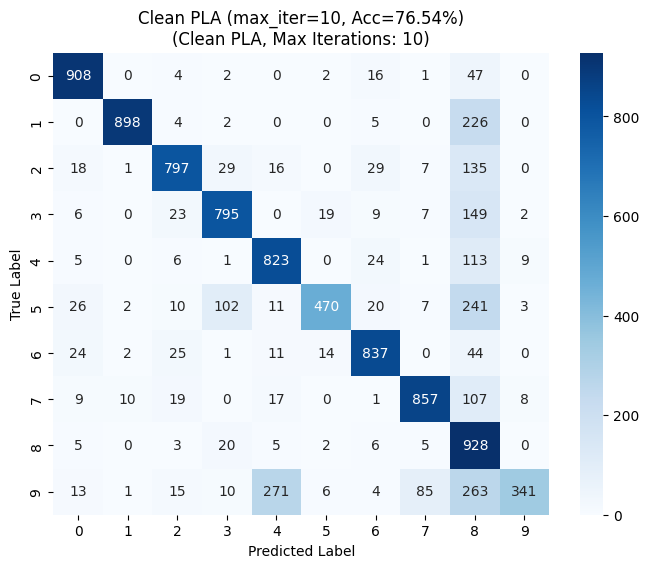

Plotting Clean Confusions:  50%|███████████████▌               | 1/2 [00:00<00:00,  7.39it/s]

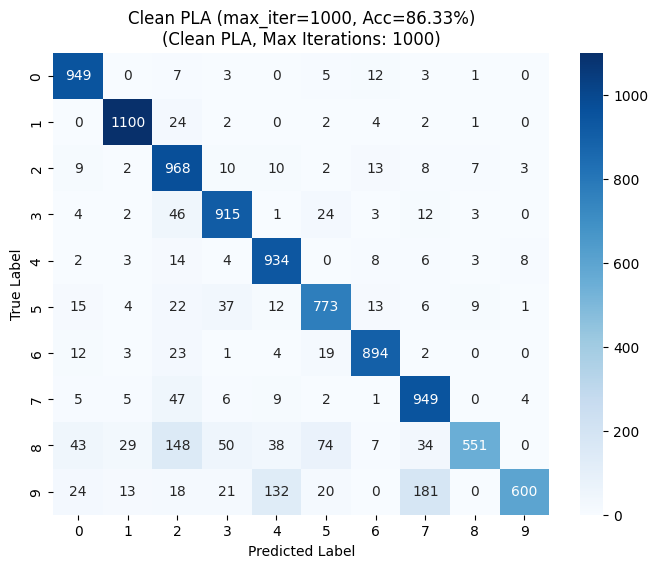

Plotting Pocket Confusions:   0%|                                      | 0/2 [00:00<?, ?it/s]

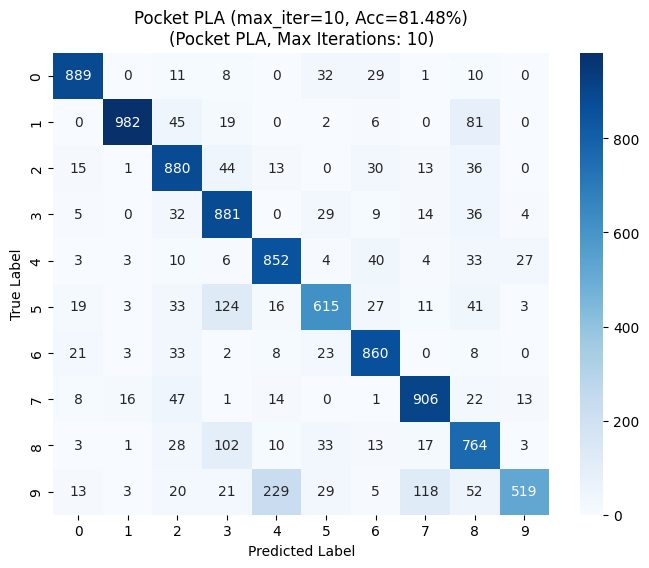

Plotting Pocket Confusions:  50%|███████████████               | 1/2 [00:00<00:00,  8.46it/s]

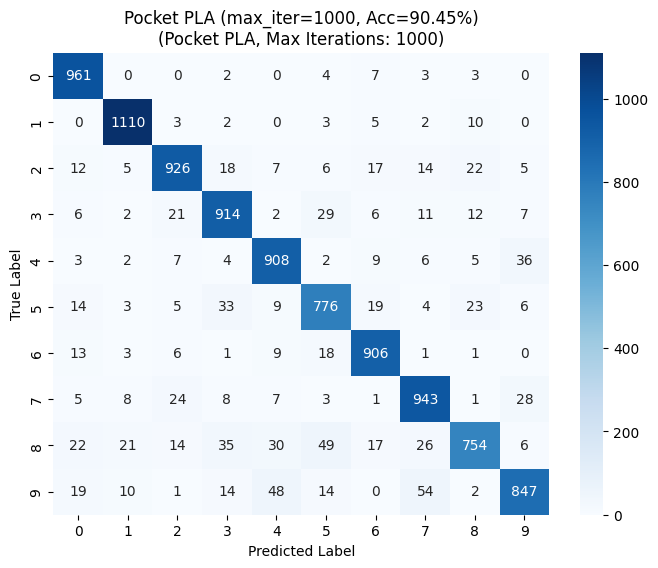

Plotting Pocket Confusions: 100%|██████████████████████████████| 2/2 [00:00<00:00,  8.47it/s]


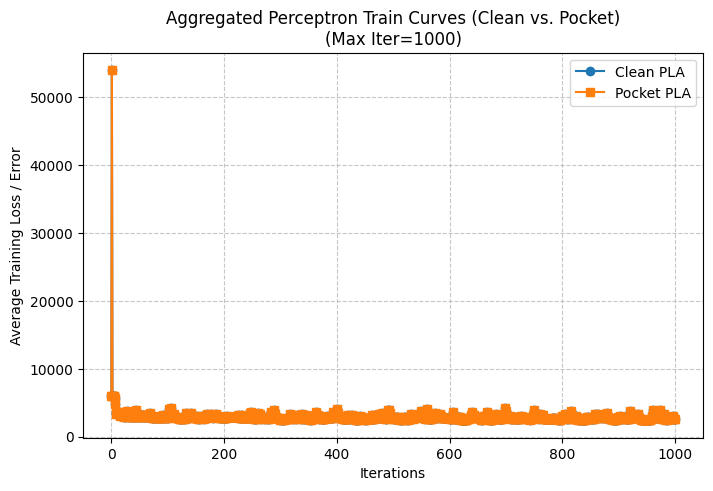

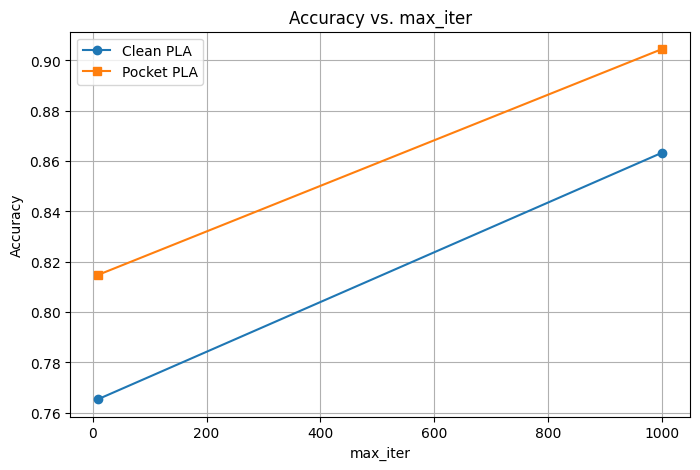

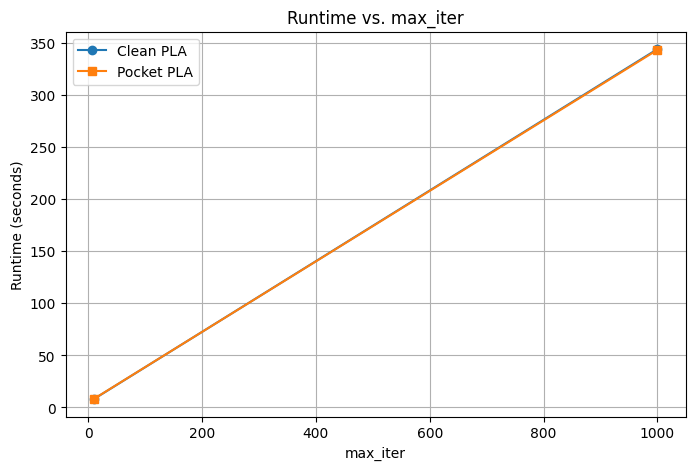

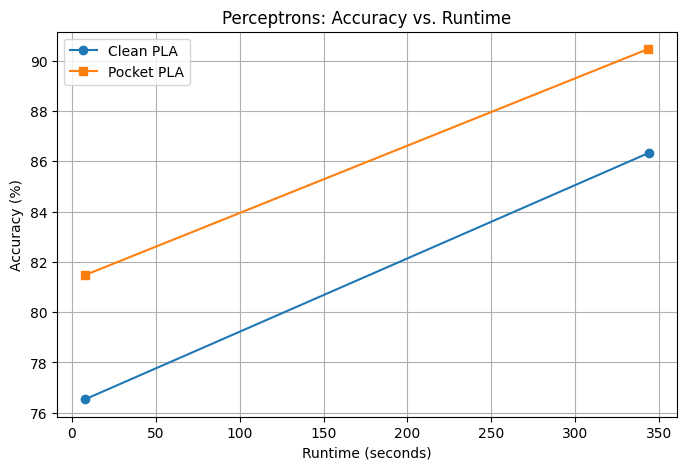

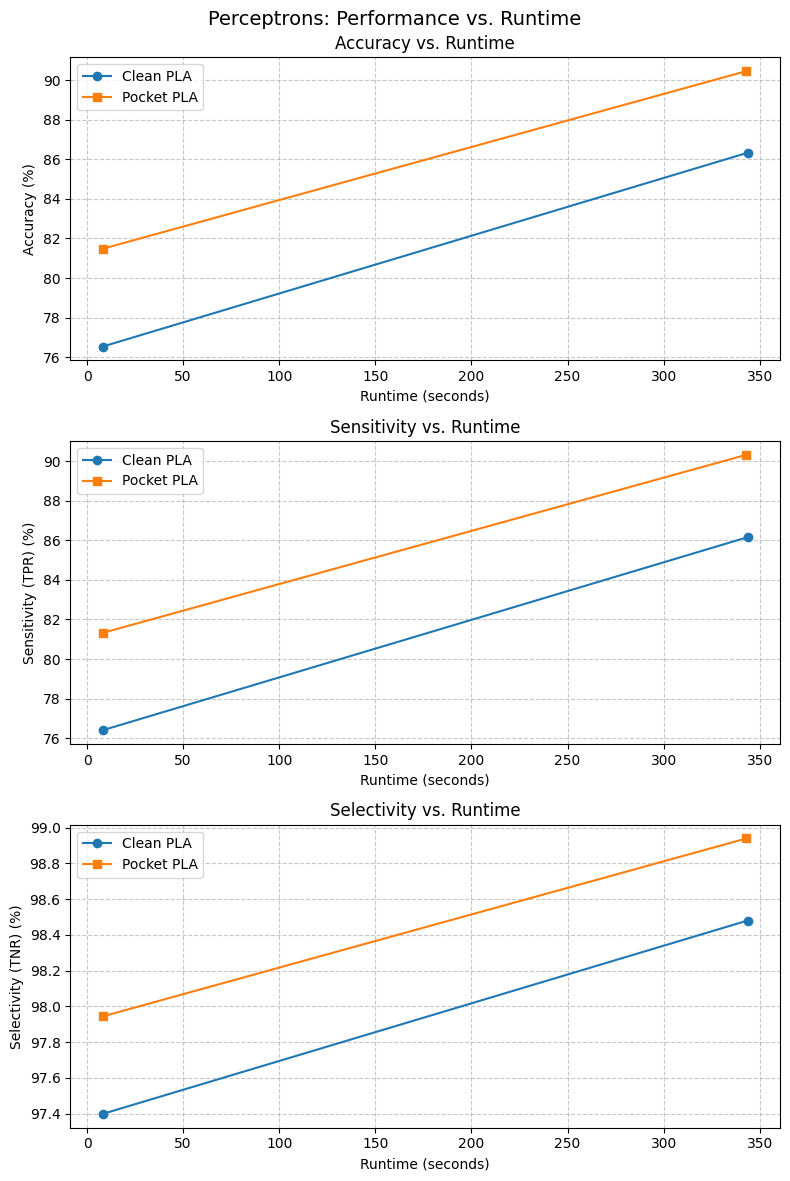

2025-03-18 13:23:25,739 - INFO - 
=== Perceptron Visualization Done ===

2025-03-18 13:23:25,739 - INFO - === Visualizing Regressions (Softmax, Linear) ===
Plotting Softmax Confusions:   0%|                                     | 0/6 [00:00<?, ?it/s]

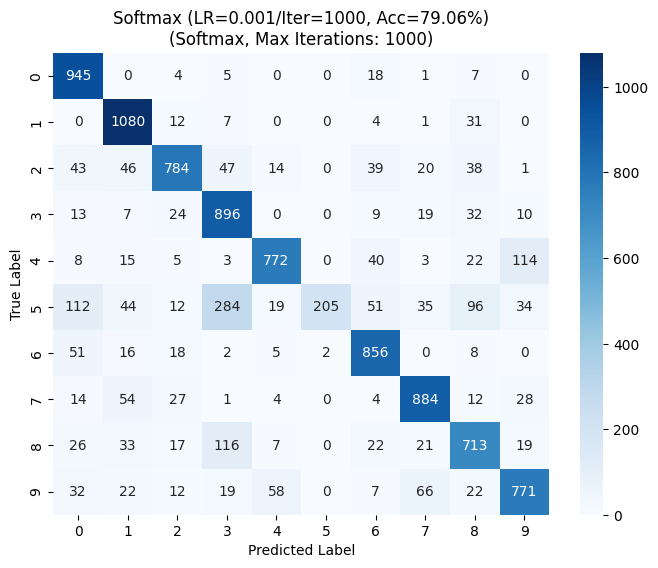

Plotting Softmax Confusions:  17%|████▊                        | 1/6 [00:00<00:00,  8.46it/s]

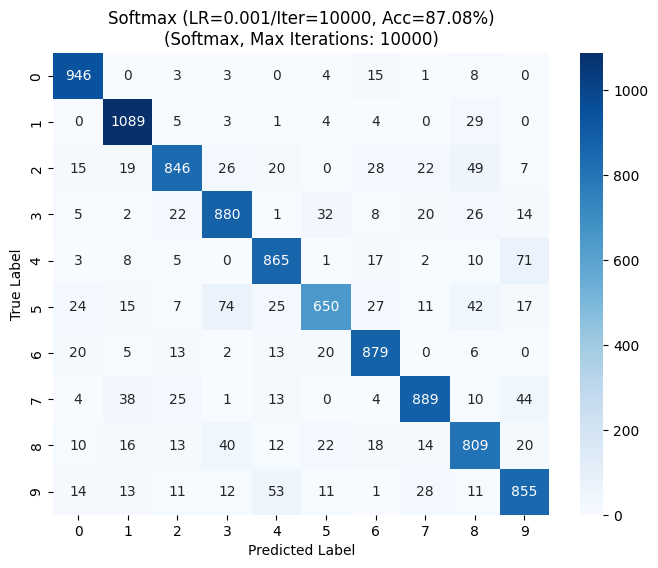

Plotting Softmax Confusions:  33%|█████████▋                   | 2/6 [00:00<00:00,  8.52it/s]

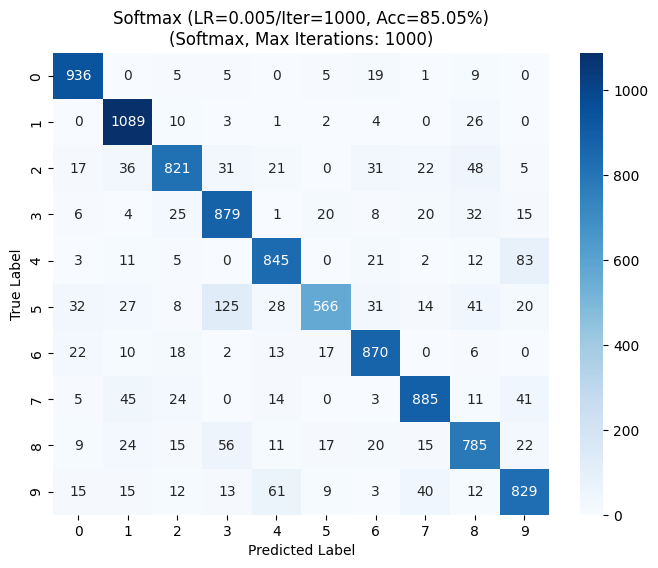

Plotting Softmax Confusions:  50%|██████████████▌              | 3/6 [00:00<00:00,  6.65it/s]

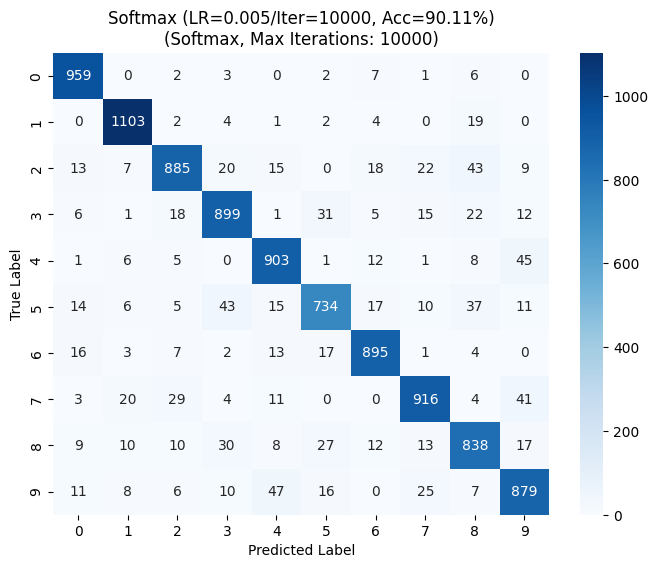

Plotting Softmax Confusions:  67%|███████████████████▎         | 4/6 [00:00<00:00,  7.35it/s]

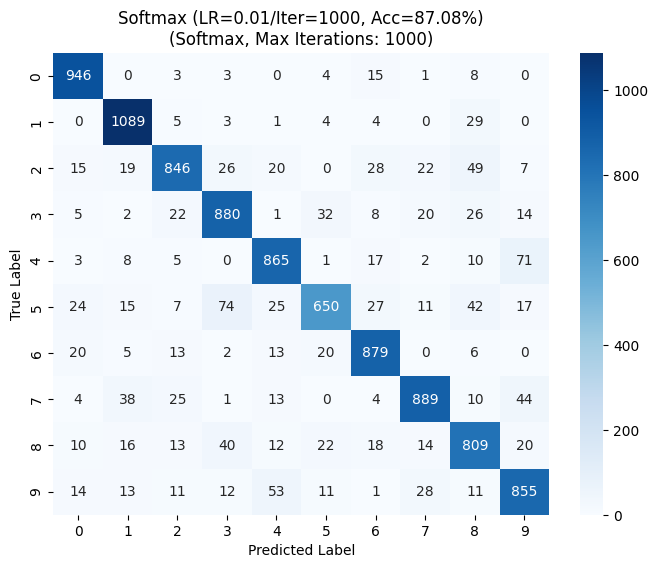

Plotting Softmax Confusions:  83%|████████████████████████▏    | 5/6 [00:00<00:00,  7.77it/s]

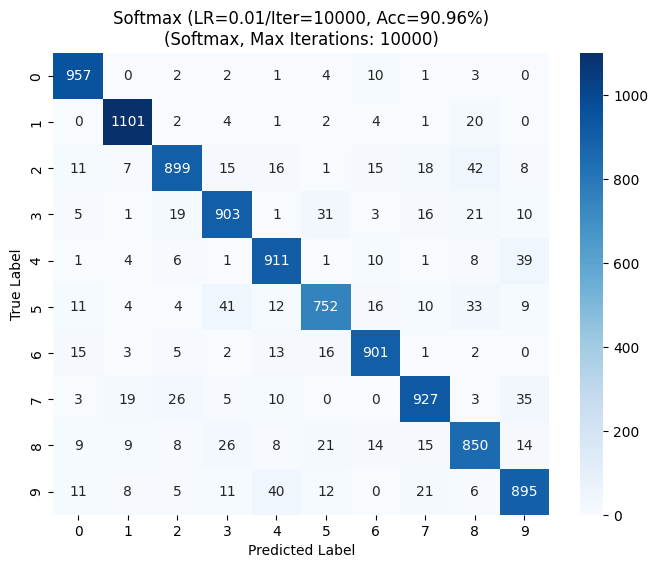

Plotting Linear Confusions:   0%|                                      | 0/6 [00:00<?, ?it/s]

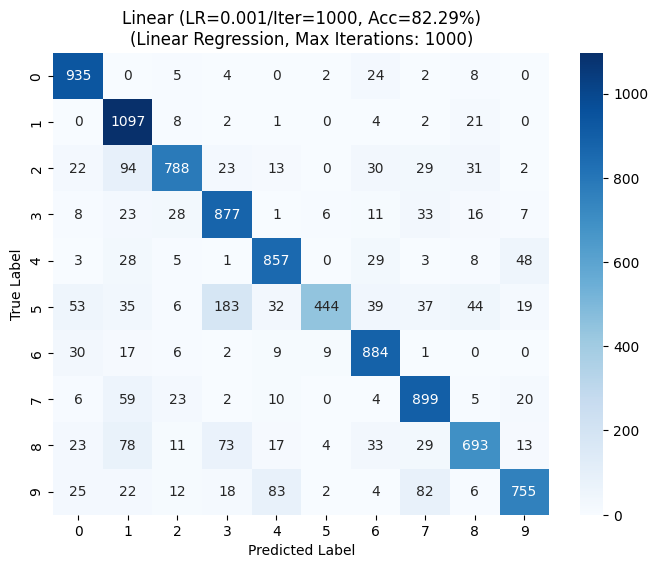

Plotting Linear Confusions:  17%|█████                         | 1/6 [00:00<00:00,  8.57it/s]

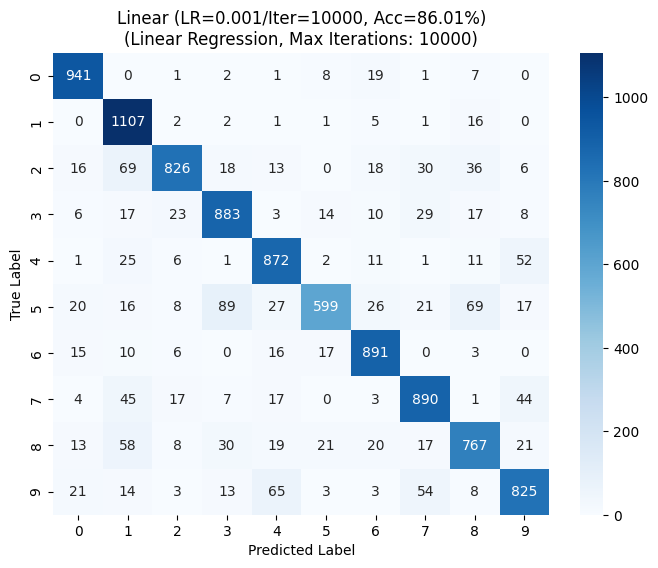

Plotting Linear Confusions:  33%|██████████                    | 2/6 [00:00<00:00,  8.71it/s]

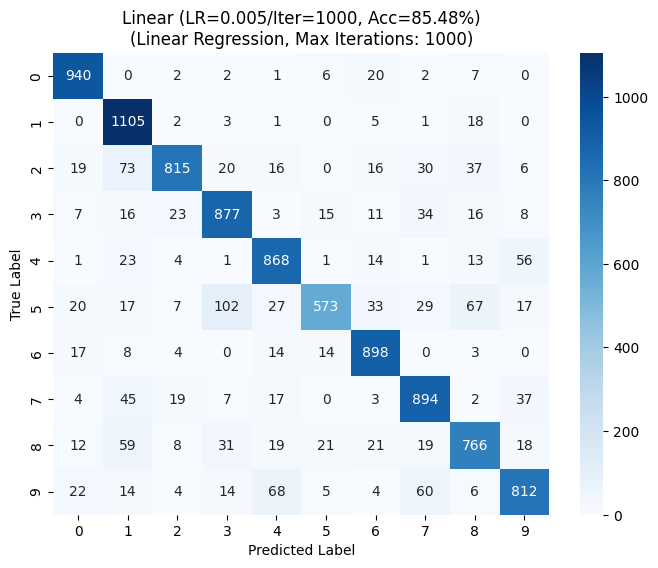

Plotting Linear Confusions:  50%|███████████████               | 3/6 [00:00<00:00,  8.63it/s]

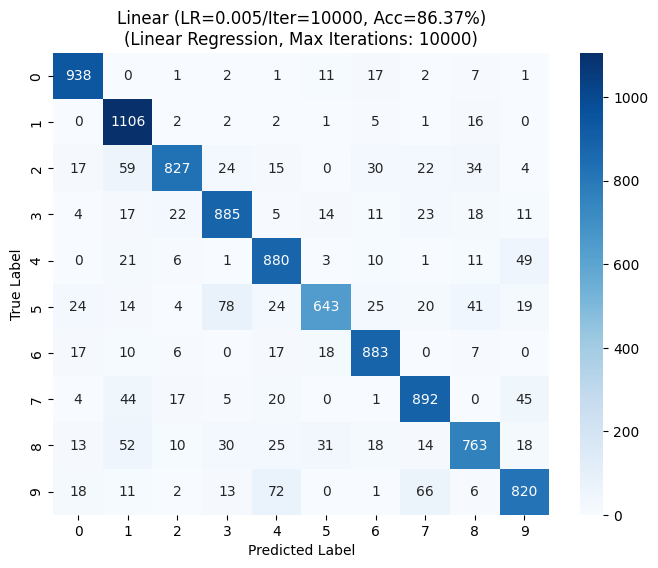

Plotting Linear Confusions:  67%|████████████████████          | 4/6 [00:00<00:00,  8.65it/s]

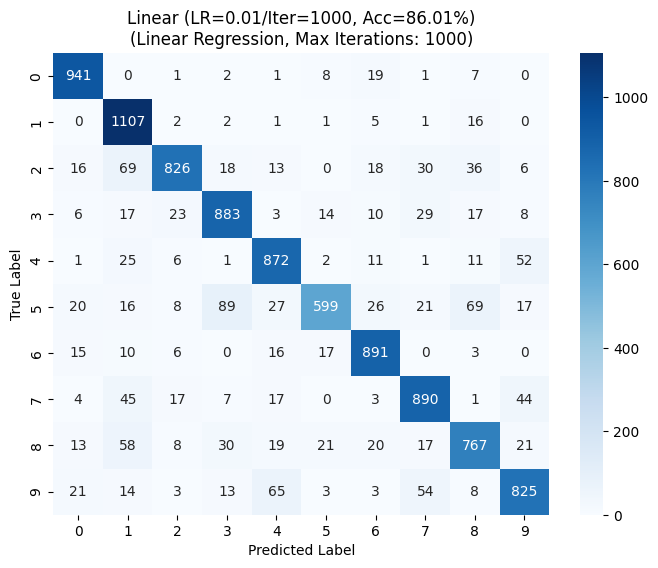

Plotting Linear Confusions:  83%|█████████████████████████     | 5/6 [00:00<00:00,  8.60it/s]

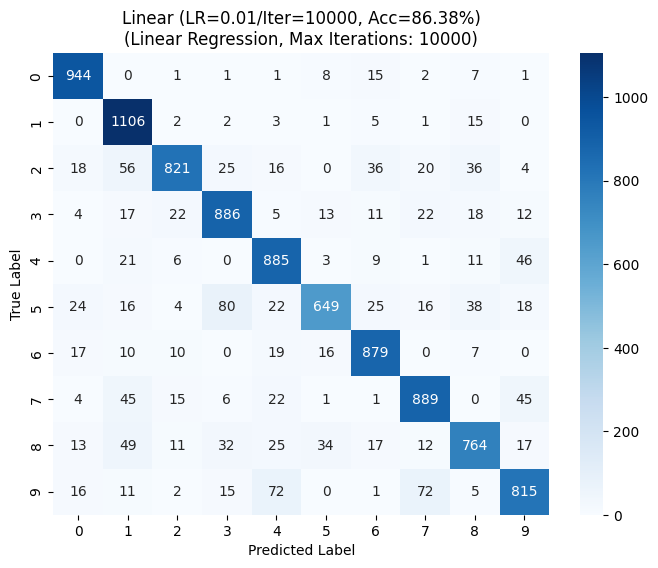

Plotting Linear Confusions: 100%|██████████████████████████████| 6/6 [00:00<00:00,  8.62it/s]


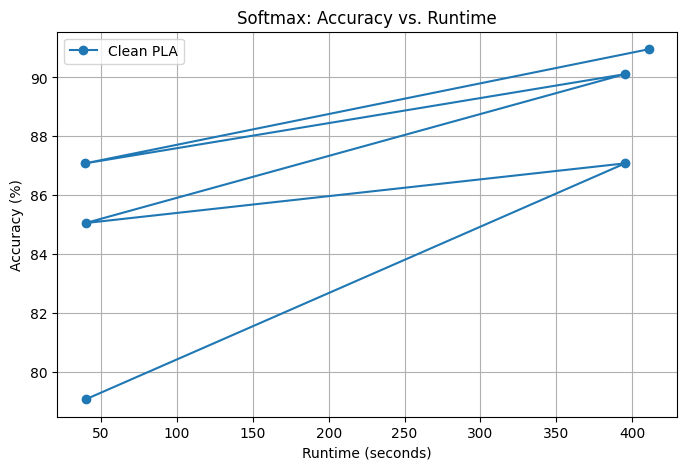

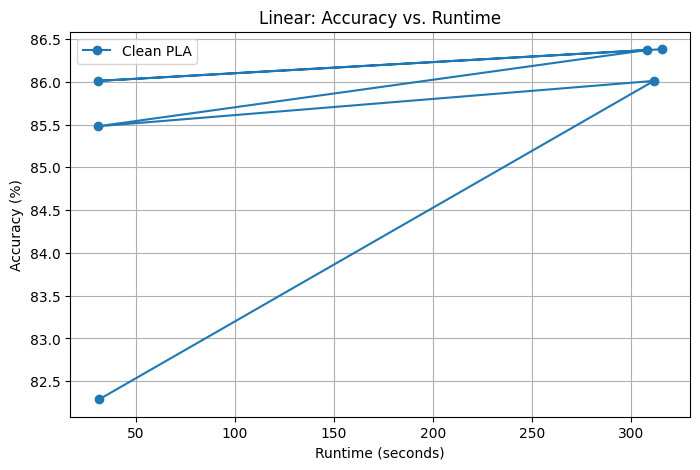

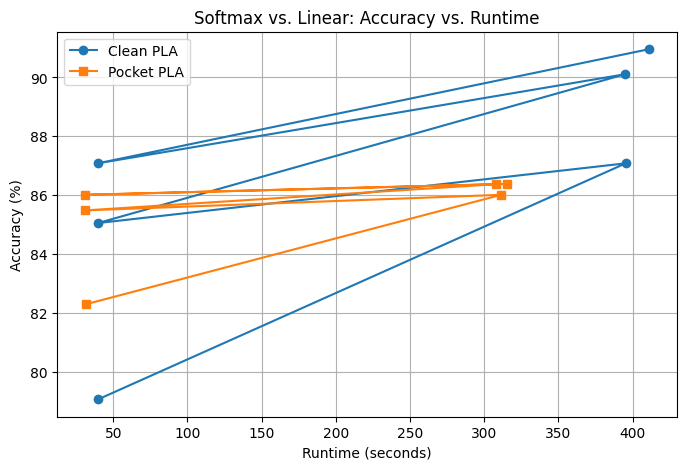

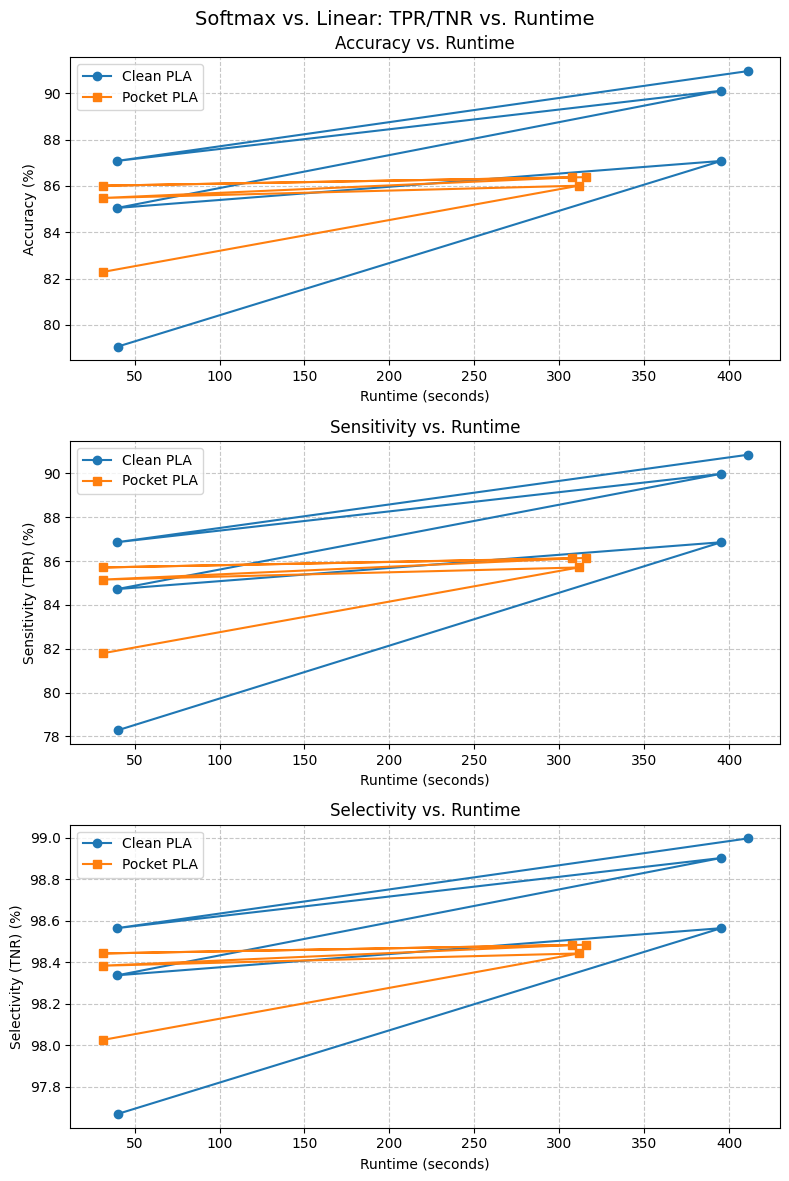

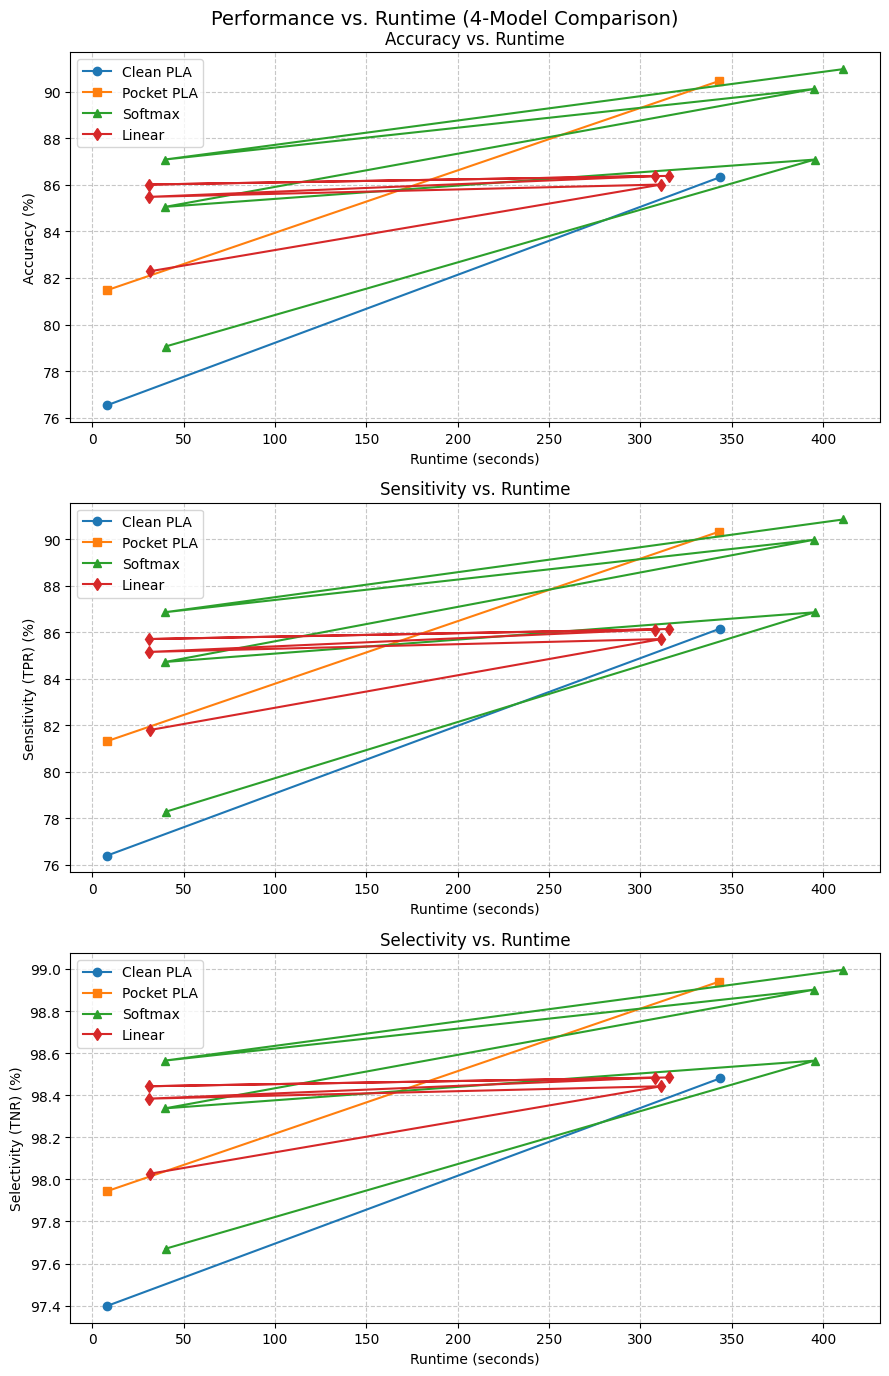

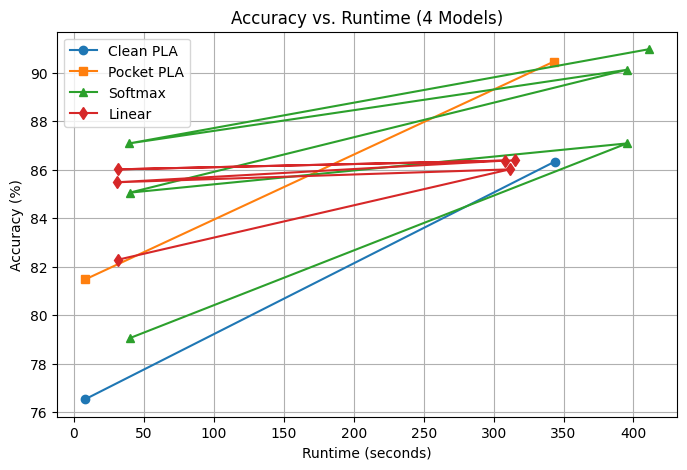

2025-03-18 13:23:27,848 - INFO - 
=== Regressions Visualization Done ===


In [8]:
##################################################
# VISUALIZATION CELL
##################################################

logger.info("=== Visualizing Perceptrons (Clean, Pocket) ===")

# --------------------------------------------------------------------------
# 1) Plot Confusion Matrices for Clean & Pocket
# --------------------------------------------------------------------------
for idx, meta in tqdm(enumerate(meta_clean), total=len(meta_clean), desc="Plotting Clean Confusions"):
    # meta should have e.g. {"max_iter": ..., "accuracy": ..., "method": ...}
    title = f"Clean PLA (max_iter={meta['max_iter']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_clean[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

for idx, meta in tqdm(enumerate(meta_pocket), total=len(meta_pocket), desc="Plotting Pocket Confusions"):
    title = f"Pocket PLA (max_iter={meta['max_iter']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_pocket[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# --------------------------------------------------------------------------
# 2) Perceptron Iteration-based Aggregated Curves
# --------------------------------------------------------------------------
plot_train_curves_three_models(
    clean_train_curve=clean_train_curve,
    pocket_train_curve=pocket_train_curve,
    softmax_train_curve=None,  # No softmax curve here
    title="Aggregated Perceptron Train Curves (Clean vs. Pocket)",
    max_iter=perceptron_max_iter_values[-1]
)

# --------------------------------------------------------------------------
# 3) Summaries (accuracy vs. max_iter, runtime vs. max_iter)
# --------------------------------------------------------------------------
plot_accuracy_vs_max_iter(
    max_iter_values=perceptron_max_iter_values,
    accuracies_clean=accuracies_clean,
    accuracies_pocket=accuracies_pocket,
    accuracies_softmax=None
)

plot_runtime_vs_max_iter(
    max_iter_values=perceptron_max_iter_values,
    runtimes_clean=runtimes_clean,
    runtimes_pocket=runtimes_pocket,
    runtimes_softmax=None
)

# --------------------------------------------------------------------------
# 4) Runtime-based Summaries (Clean vs. Pocket)
# --------------------------------------------------------------------------
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_clean,
    accuracies_clean=accuracies_clean,
    runtimes_pocket=runtimes_pocket,
    accuracies_pocket=accuracies_pocket,
    title="Perceptrons: Accuracy vs. Runtime"
)

plot_performance_summary_extended_by_runtime(
    runtimes_clean=runtimes_clean,
    accuracies_clean=accuracies_clean,
    sensitivities_clean=sensitivities_clean,
    selectivities_clean=selectivities_clean,
    runtimes_pocket=runtimes_pocket,
    accuracies_pocket=accuracies_pocket,
    sensitivities_pocket=sensitivities_pocket,
    selectivities_pocket=selectivities_pocket,
    title="Perceptrons: Performance vs. Runtime"
)

logger.info("\n=== Perceptron Visualization Done ===\n")


############################################################################
# PART B: REGRESSION MODELS (Softmax & Linear)
############################################################################
logger.info("=== Visualizing Regressions (Softmax, Linear) ===")

# --------------------------------------------------------------------------
# 1) Plot Confusion Matrices for Softmax & Linear
# --------------------------------------------------------------------------
for idx, meta in tqdm(enumerate(meta_soft), total=len(meta_soft), desc="Plotting Softmax Confusions"):
    # Instead of mode=..., we now use meta['label'] for the descriptive text:
    title = f"Softmax ({meta['label']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_soft[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

for idx, meta in tqdm(enumerate(meta_linear), total=len(meta_linear), desc="Plotting Linear Confusions"):
    title = f"Linear ({meta['label']}, Acc={meta['accuracy']*100:.2f}%)"
    plot_confusion_matrix_annotated(
        conf_linear[idx],
        classes=range(10),
        title=title,
        method=meta["method"],
        max_iter=meta["max_iter"]
    )

# --------------------------------------------------------------------------
# 2) (Optional) If you aggregated iteration-level training curves for Softmax/Linear
# --------------------------------------------------------------------------
# Example usage (uncomment if needed):
# plot_train_curves_three_models(
#     clean_train_curve=None,
#     pocket_train_curve=None,
#     softmax_train_curve=softmax_train_curve,
#     title="Softmax Aggregated Train Curve",
#     max_iter=1000  # or whichever is relevant
# )

# --------------------------------------------------------------------------
# 3) Summaries for Softmax vs. Linear (runtime-based)
# --------------------------------------------------------------------------
plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    title="Softmax: Accuracy vs. Runtime"
)

plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_linear,
    accuracies_clean=accuracies_linear,
    title="Linear: Accuracy vs. Runtime"
)

plot_accuracy_vs_runtime(
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    runtimes_pocket=runtimes_linear,
    accuracies_pocket=accuracies_linear,
    title="Softmax vs. Linear: Accuracy vs. Runtime"
)

plot_performance_summary_extended_by_runtime(
    # first model: Softmax
    runtimes_clean=runtimes_softmax,
    accuracies_clean=accuracies_softmax,
    sensitivities_clean=sensitivities_soft,
    selectivities_clean=selectivities_soft,
    # second model: Linear
    runtimes_pocket=runtimes_linear,
    accuracies_pocket=accuracies_linear,
    sensitivities_pocket=sensitivities_lin,
    selectivities_pocket=selectivities_lin,
    title="Softmax vs. Linear: TPR/TNR vs. Runtime"
)

# --------------------------------------------------------------------------
# 4) 4-Model Comparison: Clean, Pocket, Softmax, Linear
# --------------------------------------------------------------------------
plot_performance_summary_4models_by_runtime(
    runtimes_clean, accuracies_clean, sensitivities_clean, selectivities_clean,
    runtimes_pocket, accuracies_pocket, sensitivities_pocket, selectivities_pocket,
    runtimes_softmax, accuracies_softmax, sensitivities_soft, selectivities_soft,
    runtimes_linear, accuracies_linear, sensitivities_lin, selectivities_lin,
    title="Performance vs. Runtime (4-Model Comparison)"
)

plot_accuracy_vs_runtime_4models(
    rt_clean=runtimes_clean,
    acc_clean=accuracies_clean,
    rt_pocket=runtimes_pocket,
    acc_pocket=accuracies_pocket,
    rt_softmax=runtimes_softmax,
    acc_softmax=accuracies_softmax,
    rt_linear=runtimes_linear,
    acc_linear=accuracies_linear,
    title="Accuracy vs. Runtime (4 Models)"
)

logger.info("\n=== Regressions Visualization Done ===")


# Final Results Summary



**Observations:**
- **Pocket PLA** consistently outperforms Clean PLA in both accuracy and sensitivity (TPR) across all tested iteration counts.
- Increasing `max_iter` improves performance, though gains tend to plateau beyond roughly 50–100 iterations.
- **Runtime** increases nearly linearly with `max_iter` for both methods, highlighting a clear trade-off between higher accuracy and computational cost.
- Perfect linear separation is not achieved—even at higher iteration counts, neither method reaches 100% accuracy, indicating that the dataset is not strictly linearly separable.

**Trade-off Analysis:**
- **Low Iterations (max_iter = 10–30):**  
  Fast training with modest accuracy and TPR, suitable for rapid prototyping or time-sensitive applications.
- **Medium Iterations (max_iter = 50–100):**  
  Balanced performance and runtime, capturing most achievable gains without excessive overhead.
- **High Iterations (max_iter > 100):**  
  Marginal performance improvements with significant runtime increase; diminishing returns for practical applications.

**Recommendations for Future Work:**
- Experiment with alternative update rules (e.g., adaptive learning rates) to accelerate convergence.
- Compare against more sophisticated models (e.g., Logistic Regression, SVMs, neural networks) for broader insights.
- Evaluate model robustness under noisy or adversarial conditions.

This comprehensive analysis—including confusion matrices, error curves, and summary plots—provides detailed insights into the performance of the multi-class Perceptron on MNIST and informs the optimal balance between training efficiency and classification performance.
